In [2]:
import sys
import os

In [3]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [1]:
from ase.build import bulk
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.rc('figure', figsize=(18,6))
plt.rc('font', size=20)
from ase.eos import EquationOfState

# Primer test: Al fcc 

In [2]:
alfcc = bulk('Al', 'fcc', a=4., cubic=True)
calc = GPAW(mode=PW(300), xc='PBE', txt='alfcc.txt',kpts=[5,5,5])
alfcc.set_calculator(calc)
alfcc.get_potential_energy()

-14.938247719781202

# K-point convergence 

In [3]:
initialguess = {'bcc': 3.3, 'fcc': 4.0}

In [4]:
kpoints = [1,3,4,5,7,8]
Ekpt = {}

In [5]:
for struc, latpar in initialguess.items():
    structure = bulk('Al', crystalstructure=struc, a=latpar, cubic=True)
    Ekpt[struc] = np.array([])
    for kpt in tqdm(kpoints):
        calc = GPAW(mode=PW(300), txt='out.txt', xc='PBE',kpts=[kpt,kpt,kpt])
        structure.set_calculator(calc)
        Ekpt[struc]=np.append(Ekpt[struc], structure.get_potential_energy()/structure.get_global_number_of_atoms())

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

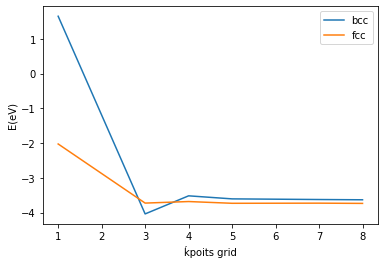

In [6]:
plots = [plt.plot(kpoints, energies, label = struc) for struc, energies in Ekpt.items()]
plt.ylabel('E(eV)')
plt.xlabel('ḱpoits grid')
plt.legend()

In [7]:
KPT = 4

# cutoff convergence

In [8]:
ecuts = [200, 250, 300, 400]
Ecutoff = {}

In [9]:
for struc, latpar in initialguess.items():
    structure = bulk('Al', crystalstructure=struc, a=latpar, cubic=True)
    Ecutoff[struc] = np.array([])
    for ecut in tqdm(ecuts):
        calc = GPAW(mode=PW(ecut), txt='out.txt', xc='PBE',kpts=[KPT,KPT,KPT])
        structure.set_calculator(calc)
        Ecutoff[struc]=np.append(Ecutoff[struc], structure.get_potential_energy()/structure.get_global_number_of_atoms())

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
Ecutoff

{'bcc': array([-3.51702079, -3.51898607, -3.51990637, -3.5206393 ]),
 'fcc': array([-3.68160509, -3.68335222, -3.68421972, -3.6850338 ])}

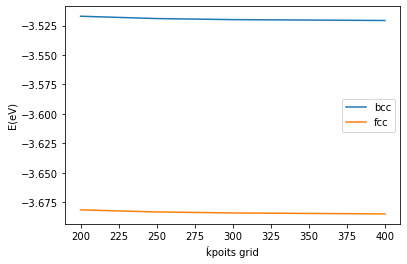

In [11]:
[plt.plot(ecuts, energies, label = struc) for struc, energies in Ecutoff.items()]
plt.ylabel('E(eV)')
plt.xlabel('ḱpoits grid')
plt.legend()

In [12]:
ECUT = 225

# Lattice Parameter

In [13]:
latparams = {'fcc': np.linspace(3.8,4.5,10), 'bcc': np.linspace(3.0, 3.6, 10)}

In [14]:
def evcurve(element, structure, sizes, calculator):
    print(f'working on {element} in {structure}')
    structures = []
    E = []
    V = []
    progress = tqdm(sizes)
    for a in progress:
        calc = GPAW(mode=PW(ECUT), xc='PBE', txt=f'{element}{structure}_{a}.txt',kpts=[KPT,KPT,KPT])
        structures.append(bulk(element, structure, a=a, cubic=True))
        structures[-1].set_calculator(calculator)
        E.append(structures[-1].get_potential_energy())
        V.append(structures[-1].get_volume())
    return {'E': E, 'V': V, 'strucs': structures}

In [15]:
evcurves = {struc: evcurve('Al',struc, thissizes, calc) for struc, thissizes in latparams.items() }

working on Al in fcc


  0%|          | 0/10 [00:00<?, ?it/s]

working on Al in bcc


  0%|          | 0/10 [00:00<?, ?it/s]

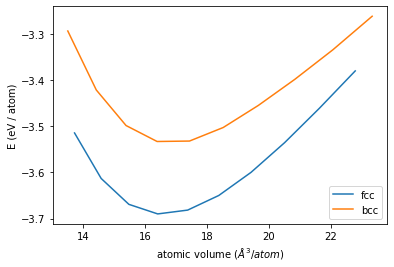

In [31]:
for struc, evcurve in evcurves.items():
    natoms = evcurve['strucs'][-1].get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=struc)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')

<AxesSubplot:>

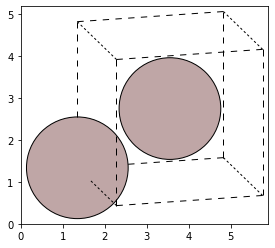

In [32]:
plot_atoms(evcurves['bcc']['strucs'][-1], rotation='15y, 15x')

<AxesSubplot:>

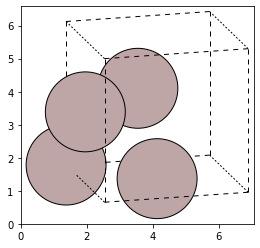

In [18]:
plot_atoms(evcurves['fcc']['strucs'][-1], rotation='15y, 15x')

# Ecuación de Estado 

In [19]:
eos = EquationOfState(evcurves['fcc']['V'],evcurves['fcc']['E'],eos='birchmurnaghan')

In [20]:
eos.fit()

(66.22762521910393, -14.759967369775243, 0.49791609505250944)

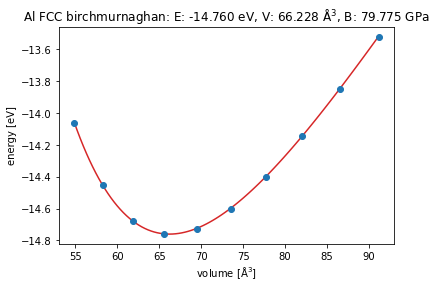

In [21]:
ax = eos.plot()
title = ax.get_title()
newtitle = ax.set_title('Al FCC ' + title)

In [22]:
eqa = eos.v0**(1/3)

In [23]:
eqa

4.045880589525278

# Densidad de Estados 

In [24]:
eqstruc = bulk('Al','fcc',a=eqa, cubic=True)
calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[11,11,11], txt='equilibrium.txt')
eqstruc.set_calculator(calc)
eqstruc.get_potential_energy()

e,dos = eqstruc.calc.get_dos(npts=500)
ef = eqstruc.calc.get_fermi_level()

Text(0, 0.5, 'DOS')

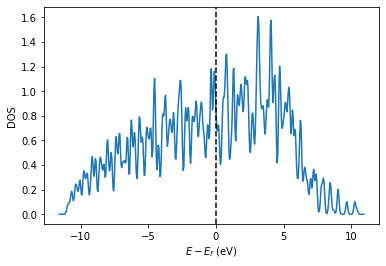

In [25]:
plt.plot(e-ef,dos)
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')

In [26]:
eqstruc.calc.write('Alfcceq.gpw')

In [27]:
bscalc = GPAW('Alfcceq.gpw').fixed_density(nbands=20, symmetry='off', txt='bs.txt', kpts={'path': 'GXMGRX', 'npoints': 60}, convergence={'bands': 8})

In [28]:
bs = bscalc.band_structure()

In [29]:
bs = bs.subtract_reference()

Text(0, 0.5, '$E-E_f$ (eV)')

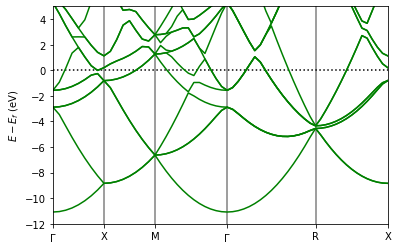

In [30]:
ax = bs.plot(emin=-12, emax=5)
ax.set_ylabel('$E-E_f$ (eV)')